In [2]:
!pip3 install -U scikit-learn
!pip3 install torch torchvision torchaudio
!pip3 install pickle


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd 
import numpy as np
import math 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
import random

import torch
from torch import nn
from torch.nn import functional as F

import pickle 

Unpacking the data

In [3]:
with open('../data/sampled_filters_train.pkl', 'rb') as f:
    data = pickle.load(f)

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [4]:
wavelengths = data['wavelengths']
spectra = data['spectra']
z = data['z']
X = data['X']
df_X = pd.DataFrame(X)
names=data['filter_names']
filter_wls = [int(name[1:-1].rstrip('W')) for name in names]
indices=[0,10,30,500,15000,800000]

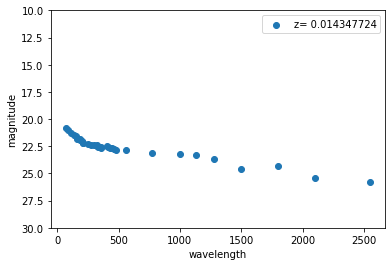

In [31]:
for i in range(1):
    plt.scatter(filter_wls, X[i], label = "z= "+str(z[i,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()
plt.show()



In [86]:
def add_noise(X, T = 1):
    if T != 1:
        beta1, beta2 = 0.0001, 0.2
        beta_t = np.arange(beta1, beta2 + 0.0001, (beta2 - beta1)/(T - 1) )
    else: 
        beta_t = [0.0001]
    for t in range(T):
        mu, sigma = math.sqrt(1 - beta_t[t]) * X, beta_t[t] * np.identity(len(X))
        X1 = np.random.multivariate_normal(mu, sigma)
    return X1



In [114]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu1 = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.relu2 = nn.ReLU(inplace=True)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        return x

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.pool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x):
        x = self.pool(x)
        x = self.conv(x)
        return x

class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose1d(in_channels//2, in_channels//2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels)
        
    def forward(self, x1, x2):
        x1 = self.up(x1)
        diff = x2.size()[2] - x1.size()[2]
        x1 = F.pad(x1, (diff // 2, diff // 2))
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = Down(1, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        self.up1 = Up(512, 256)
        self.up2 = Up(256, 128)
        self.up3 = Up(128, 64)
        self.up4 = Up(64, 1)
        
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        x = self.up1(x4, x3)
        x = self.up2(x, x2)
        x = self.up3(x, x1)
        x = self.up4(x, x)
        return x
    
class UNetDown(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.down1 = Down(1, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 512)
        
    def forward(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        return x4

In [148]:
m = nn.Conv1d(1, 2, kernel_size = 3, stride=3)
input = torch.randn(1, 1, 10)
print(input)
m(input)

tensor([[[-0.4820,  0.3237,  0.4067,  0.7738,  0.0581, -1.6415,  0.2577,
           0.0961, -0.0527,  1.1894]]])


tensor([[[ 0.5211, -0.5224,  0.2961],
         [ 0.2479, -0.7908, -0.1394]]], grad_fn=<ConvolutionBackward0>)

In [3]:
print("yo12312312312")

yo12312312312


In [120]:
net = UNetDown().double()
X0 = add_noise(X[0], T = 100)
X0 = torch.tensor(X0).unsqueeze(0).unsqueeze(0)
net(X0.double())

TypeError: super(type, obj): obj must be an instance or subtype of type

In [113]:
net = UNet()
X0 = add_noise(X[0], T = 100)
batch_size = 1
X0 = torch.tensor(X0).unsqueeze(0).unsqueeze(0)
print(X0.float())
net = net.double()
print(len(X[0]))

out = net(X0.double())
print((out))

tensor([[[17.7678, 18.5474, 18.7502, 19.0901, 19.1369, 20.1218, 52.7721,
          19.8517, 19.0557, 19.6441, 19.3892, 19.4138, 19.8288, 19.4306,
          19.7384, 20.1978, 20.5398, 19.4815, 20.8345, 20.1748, 19.9859,
          20.6831, 19.8076, 21.2456, 20.4919, 52.3810, 52.6773, 20.5199,
          20.4909, 20.8542, 21.1435, 20.8066, 20.4803, 22.2473, 22.7819,
          23.2112, 23.8732]]])
37


RuntimeError: Given transposed=1, weight of size [256, 256, 2], expected input[1, 512, 2] to have 256 channels, but got 512 channels instead

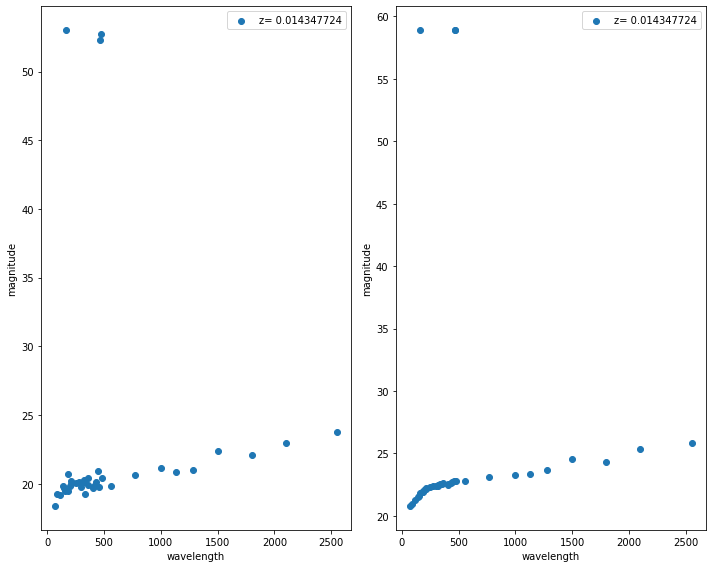

In [69]:
plt.figure(figsize= (10, 8))

plt.subplot(1, 2, 2)
plt.scatter(filter_wls, X[0], label = "z= "+str(z[i,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()

plt.subplot(1, 2, 1)
plt.scatter(filter_wls, X0, label = "z= "+str(z[0,0]))
plt.ylabel("magnitude")
#plt.ylim(30,10)
plt.xlabel("wavelength")
plt.legend()



plt.tight_layout()
plt.show()


In [49]:
X[0]

array([20.786884, 20.960768, 21.265028, 21.509062, 21.601727, 21.808668,
       58.9     , 21.899237, 21.870485, 22.042837, 22.1664  , 22.201782,
       22.337282, 22.382853, 22.393621, 22.491522, 22.391426, 22.527351,
       22.557444, 22.61449 , 22.445515, 22.539598, 22.658358, 22.670202,
       22.752363, 58.9     , 58.9     , 22.814674, 22.803913, 23.091652,
       23.25525 , 23.325388, 23.654198, 24.586325, 24.331484, 25.391253,
       25.81203 ], dtype=float32)

In [50]:
X0

array([18.18387858, 19.11158712, 18.77033567, 18.73173945, 19.83147745,
       19.76799058, 52.53073971, 19.24033204, 19.82485043, 19.58854701,
       19.18816197, 20.34733135, 19.80594306, 20.61285027, 20.00532452,
       19.72817818, 20.04521396, 20.65350765, 20.20638097, 19.88978372,
       20.32575284, 19.93396853, 20.56848211, 20.20734979, 20.52066788,
       52.92152031, 52.14634073, 20.77923495, 20.89681471, 21.11384064,
       21.1684129 , 21.25573751, 21.35002085, 21.63235812, 22.5197138 ,
       22.67553267, 23.9491519 ])